In [1]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.3 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incomp

In this section we load the triples into train, test and validation from the FB15k-237 dataset. This dataset contains three sections which represent, intuitively, train test and validation. Each is divided into triples, containing a head (subject of the phrase), a relation and a tail (object of the phrase). 

There are two possible versions of this dataset: 
- FB15K, which is the original version
- FB15K-237, which is the one I use. This second version only keeps 237 possible relations, and filters out the problematic ones which were found in the previous version of the dataset.

In my case, the choice was made also because of the encoding which is later used, which was only found for this specific version of the dataset. Since in the task description I was left free to choose I have decided to use this second, newer version.

In [2]:
from datasets import load_dataset
import tqdm as notebook_tqdm
# FB15k-237 from HuggingFace
dataset = load_dataset("VLyb/FB15k-237")

train_triples = dataset["train"]
test_triples = dataset["test"]
valid_triples = dataset["validation"]
print(train_triples[0])

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/272115 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17535 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20466 [00:00<?, ? examples/s]

{'head': '/m/027rn', 'relation': '/m/06cx9', 'tail': '/location/country/form_of_government'}


In [3]:
print(train_triples[0])
print(train_triples[1])
print(train_triples[2])

{'head': '/m/027rn', 'relation': '/m/06cx9', 'tail': '/location/country/form_of_government'}
{'head': '/m/017dcd', 'relation': '/m/06v8s0', 'tail': '/tv/tv_program/regular_cast./tv/regular_tv_appearance/actor'}
{'head': '/m/07s9rl0', 'relation': '/m/0170z3', 'tail': '/media_common/netflix_genre/titles'}


In [4]:
print(test_triples[0])
print(test_triples[1])
print(test_triples[2])

{'head': '/m/08966', 'relation': '/m/05lf_', 'tail': '/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month'}
{'head': '/m/01hww_', 'relation': '/m/01q99h', 'tail': '/music/performance_role/regular_performances./music/group_membership/group'}
{'head': '/m/09v3jyg', 'relation': '/m/0f8l9c', 'tail': '/film/film/release_date_s./film/film_regional_release_date/film_release_region'}


In [5]:
print(valid_triples[0])
print(valid_triples[1])
print(valid_triples[2])

{'head': '/m/07pd_j', 'relation': '/m/02l7c8', 'tail': '/film/film/genre'}
{'head': '/m/06wxw', 'relation': '/m/02fqwt', 'tail': '/location/location/time_zones'}
{'head': '/m/01t94_1', 'relation': '/m/04ztj', 'tail': '/people/person/spouse_s./people/marriage/type_of_union'}


As we see here it looks like the relation and tail are inverted. This makes the evaluation of model performance meaningless if it is not corrected. Therefore we will fix it in the following way:

In [6]:
def fix_fields(example):
    return {
        "head": example["head"],
        "relation": example["tail"],
        "tail": example["relation"]
    }

train_dataset = dataset["train"].map(fix_fields)
valid_dataset = dataset["validation"].map(fix_fields)
test_dataset  = dataset["test"].map(fix_fields)



Map:   0%|          | 0/272115 [00:00<?, ? examples/s]

Map:   0%|          | 0/17535 [00:00<?, ? examples/s]

Map:   0%|          | 0/20466 [00:00<?, ? examples/s]

Training on a subset of the dataset was done in order to be able to speed up the process

In [7]:
train_subset_size = 10000
val_test_subset_size = 2000

train_triples = train_dataset.select(range(train_subset_size))
valid_triples = valid_dataset.select(range(val_test_subset_size))
test_triples  = test_dataset.select(range(val_test_subset_size))

In [8]:
len(train_triples)

10000

In [9]:
print(train_triples[0])
print(train_triples[1])
print(train_triples[2])

{'head': '/m/027rn', 'relation': '/location/country/form_of_government', 'tail': '/m/06cx9'}
{'head': '/m/017dcd', 'relation': '/tv/tv_program/regular_cast./tv/regular_tv_appearance/actor', 'tail': '/m/06v8s0'}
{'head': '/m/07s9rl0', 'relation': '/media_common/netflix_genre/titles', 'tail': '/m/0170z3'}


In [10]:
# use only a subset of the data. This is done as my laptop does not have a GPU and therfore struggles
# subset_size = 10000

# train_triples = train_triples.select(range(subset_size))
# valid_triples = valid_triples.select(range(2000))
# test_triples = test_triples.select(range(2000))

* load the mapping of entities and relations

In [11]:
!wget https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/entity2text.txt
!wget https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/relation2text.txt

# Load entity names
entity_map = {}
with open("entity2text.txt", encoding="utf-8") as f:
    for line in f:
        eid, name = line.strip().split('\t')
        entity_map[eid] = name

# Load relation names
relation_map = {}
with open("relation2text.txt", encoding="utf-8") as f:
    for line in f:
        rid, name = line.strip().split('\t')
        relation_map[rid] = name


def triple_to_sentence(h, r, t, entity_map = entity_map, relation_map = relation_map):
    h_text = entity_map.get(h, h)
    r_text = relation_map.get(r, r.replace("/", " ").replace("_", " "))
    t_text = entity_map.get(t, t)
    return f"{h_text} {r_text} {t_text}."

--2025-08-18 16:48:17--  https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/entity2text.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392383 (383K) [text/plain]
Saving to: ‘entity2text.txt’

entity2text.txt     100%[===================>] 383.19K  --.-KB/s    in 0.03s   

2025-08-18 16:48:17 (11.3 MB/s) - ‘entity2text.txt’ saved [392383/392383]

--2025-08-18 16:48:17--  https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/relation2text.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [12]:
h = train_triples[0]['head']
r = train_triples[0]['relation']
t = train_triples[0]['tail']
sentence = triple_to_sentence(h, r, t, entity_map, relation_map)
sentence

'Dominican Republic location country form of government Republic.'

This looks as expected, and it looks more like a human-readable phrase which can be used by modernBERT comfortably. 

**Why is this?**

ModernBERT, being a pretrained language model, works best on human-readable phrases. Therefore, converting the ids which are used for head, relation and tail, is necessary as it is the only way that we can take advantage of this pretraining. This will be later on proved by the results of the experiments as well as the counter-example which can be found at the very end of this notebook. 

In [13]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer -- ModernBERT
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model = AutoModel.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-08-18 16:48:43.121167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755535723.467234      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755535723.564438      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

ModernBertModel(
  (embeddings): ModernBertEmbeddings(
    (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (layers): ModuleList(
    (0): ModernBertEncoderLayer(
      (attn_norm): Identity()
      (attn): ModernBertAttention(
        (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
        (rotary_emb): ModernBertRotaryEmbedding()
        (Wo): Linear(in_features=768, out_features=768, bias=False)
        (out_drop): Identity()
      )
      (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): ModernBertMLP(
        (Wi): Linear(in_features=768, out_features=2304, bias=False)
        (act): GELUActivation()
        (drop): Dropout(p=0.0, inplace=False)
        (Wo): Linear(in_features=1152, out_features=768, bias=False)
      )
    )
    (1-21): 21 x ModernBertEncoderLayer(
      (attn_norm): LayerNorm((768,), eps=1e-05, e

In [14]:
import torch

# score a sentence -- we would like a higher positive or negative score depending on the sentence

@torch.no_grad()
def score_sentence(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    score = torch.norm(cls_embedding, p=2, dim=1)
    return score.item()


In [15]:
# get a set containing all the entities in any of the three sets
all_entities = set()

for split in [train_triples, test_triples, valid_triples]:
    for row in split:
        all_entities.update([row["head"], row["tail"]])
all_entities = list(all_entities)


In [16]:
import random

# corrupt either the head or the tail
def corrupt_triple(triple, entity_list):
    head, relation, tail = triple
    if random.random() < 0.5:
        # Corrupt tail
        corrupted = (head, relation, random.choice(entity_list))
    else:
        # Corrupt head
        corrupted = (random.choice(entity_list), relation, tail)
    return corrupted

In [17]:
# Pick a positive triple
pos = test_triples[0]
pos_triple = (pos["head"], pos["relation"], pos["tail"])

# Corrupt it
neg_triple = corrupt_triple(pos_triple, all_entities)

# Convert to sentences
pos_sentence = triple_to_sentence(*pos_triple, entity_map, relation_map)
neg_sentence = triple_to_sentence(*neg_triple, entity_map, relation_map)

# Score both
pos_score = score_sentence(pos_sentence)
neg_score = score_sentence(neg_sentence)

print(f"Positive score: {pos_score:.4f}")
print(f"Negative score: {neg_score:.4f}")

Positive score: 36.1393
Negative score: 36.7227


using bert alone, with a basic loss function and no training shows that the model is not attuned enough to this type of task and the difference between positive (indicating that the triple is correct) and negative (triple is incorrect) scores is too mild for it to be acceptable. Therefore some steps need to be taken in order to make it better


- build a dataset which contains the triples labelled (corrupted or not)


In [18]:
# check that the lenght of the triples is correct
len(train_triples)

10000

In [19]:
train_triples[0]

{'head': '/m/027rn',
 'relation': '/location/country/form_of_government',
 'tail': '/m/06cx9'}

Since we are using modernbert, the entities and relations need to make sense to be able to use its pretraining

The following function is used to generate corrupted (negative) triples for training. It randomly replaces either the head or the tail entity of a given triple with a different entity from the dataset.

In [20]:
import random

# corrupt either the head or the tail
def corrupt_triple2(triple, entity_list):
    h, r, t = triple['head'], triple['relation'], triple['tail']
    if random.random() < 0.5:
        corrupted = (random.choice(entity_list), r, t)
    else:
        corrupted = (h, r, random.choice(entity_list))
    return corrupted

The following code snipped instead creates the data which will be used in training, testing and validation. First it creates a positive example simply taking head, relation and tail from the dataset, transforming it into a sentence and labelling it with 1. In the second case, instead, the triple is first corrupted, then transformed into a sentence and labelled 0. This creates a binary classification task. 

In [21]:
def make_labeled_data(triples, all_entities, corrupt_fn, entity_map, relation_map):
    data = []
    for triple in triples:
        h, r, t = triple["head"], triple["relation"], triple["tail"]
        pos_sentence = triple_to_sentence(h, r, t, entity_map, relation_map)
        data.append((pos_sentence, 1))

        ch, cr, ct = corrupt_fn(triple, all_entities)
        neg_sentence = triple_to_sentence(ch, cr, ct, entity_map, relation_map)
        data.append((neg_sentence, 0))
    return data

# create the proper data to train, validate and test the model
# each is going to contain double the data they start with as for every triple we have a positive and a negative
train_data = make_labeled_data(train_triples, all_entities, corrupt_triple2, entity_map, relation_map)
val_data = make_labeled_data(valid_triples, all_entities, corrupt_triple2, entity_map, relation_map)
test_data = make_labeled_data(test_triples, all_entities, corrupt_triple2, entity_map, relation_map)


The following function tokenizes each sentence using the pretrained tokenizer with padding/truncation (max_length=32) and attaches the label.

In [22]:
# tokenize the data
def tokenize_data(data):
    tokenized = []
    for sentence, label in data:
        encoded = tokenizer(sentence, truncation=True, padding='max_length', max_length=32, return_tensors='pt')
        tokenized.append({
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        })
    return tokenized

train_tokenized = tokenize_data(train_data)
val_tokenized = tokenize_data(val_data)
test_tokenized = tokenize_data(test_data)


- create a torch dataset

In [23]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)

The function below is a custom collate function. Basically, when using a DataLoader, each batch is created by combining individual examples from your dataset. The collate_fn function defines how this combination should happen.

In [24]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "label": torch.stack([item["label"] for item in batch])
    }

In [25]:
from torch.utils.data import Dataset, DataLoader

class PreTokenizedDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

train_loader = DataLoader(PreTokenizedDataset(train_tokenized), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(PreTokenizedDataset(val_tokenized), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(PreTokenizedDataset(test_tokenized), batch_size=32, collate_fn=collate_fn)



The pre-tokenization of the dataset is also done to speed up the process of training. 

- add classification head

In [26]:
import torch.nn as nn
from transformers import AutoModel

class TripleClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.encoder = base_model
        self.classifier = nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls).squeeze(-1)
        return logits



In [27]:
# check where the code is running
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the model
base_model = AutoModel.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model = TripleClassifier(base_model)
model.to(device)
print(next(model.parameters()).device)

cuda:0


- train the model

The chosen learning rate was proved to be commonly used when dealing with pretrained language models. 

The loss is also common in binary classification tasks. 

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
model.train()

TripleClassifier(
  (encoder): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      )
      (1-21): 2

- this is not good, let us try to use train and validation

In [29]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=2e-1)
# criterion = nn.BCEWithLogitsLoss()

In [30]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

    model.train()
    accuracy = total_correct / total_examples
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy


In [31]:
print(next(iter(train_loader))["input_ids"].device)

cpu


In [32]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

- training loop 

In [33]:
for epoch in range(5):
    total_train_loss = 0
    total_train_correct = 0
    total_train_examples = 0
    model.train()

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        total_train_correct += (preds == labels).sum().item()
        total_train_examples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = total_train_correct / total_train_examples

    avg_val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


W0818 16:49:21.839000 36 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch 1 | Train Loss: 0.5104 | Train Acc: 0.7263 | Val Loss: 0.3175 | Val Acc: 0.8740
Epoch 2 | Train Loss: 0.2934 | Train Acc: 0.8827 | Val Loss: 0.2815 | Val Acc: 0.8910
Epoch 3 | Train Loss: 0.2223 | Train Acc: 0.9138 | Val Loss: 0.2953 | Val Acc: 0.8898
Epoch 4 | Train Loss: 0.1760 | Train Acc: 0.9330 | Val Loss: 0.3367 | Val Acc: 0.8842
Epoch 5 | Train Loss: 0.1228 | Train Acc: 0.9544 | Val Loss: 0.3701 | Val Acc: 0.8730


What was found is that since the model performs quite well a small amount of epochs is enough to reach good results. Other strategies were tried at the beginning, before figuring out the correct approach to the problem, which involved experimentations with more epochs, with different criteria and learning rates, but they were all unnecessary when the correct data was passed to the model. A simpler approach proved to be the best

In [34]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Test Loss: 0.3629 | Test Accuracy: 0.8792


In [35]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend((probs > 0.5).float().cpu().numpy())


In [36]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.9297    0.8205    0.8717      2000
         1.0     0.8394    0.9380    0.8860      2000

    accuracy                         0.8793      4000
   macro avg     0.8846    0.8792    0.8788      4000
weighted avg     0.8846    0.8792    0.8788      4000



In [37]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(all_labels, all_probs)
print(f"ROC AUC: {auc:.4f}")

ROC AUC: 0.9313


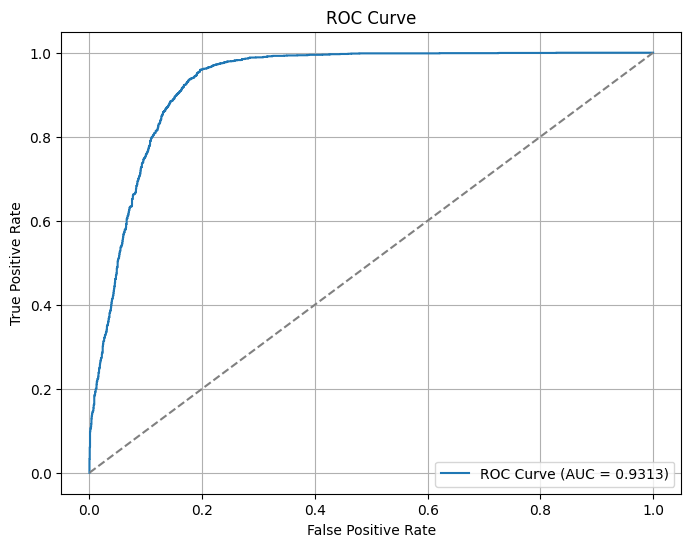

In [38]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


**Analysis of results**:

The results are good, indicating that the experiments was successful. 

Still, if we want to underline the negative sides, some could argue that accuracy and roc score are quite high, which might be a sign that something is not working correctly. Still, my interpretation of the results is the following:

*   Having corrupted relations instead of proper negative ones makes for an easier task to complete for the model, which means that we would generally expect a higher test accuracy
* Having well-formed inputs with BERT encoders (like we have here with the mapping of entities and relations) takes advantage of the pretraining, and therefore makes the task easier
*   The patterns of positive and negative examples are fairly similar, meaning that the model learns in a much smoother way



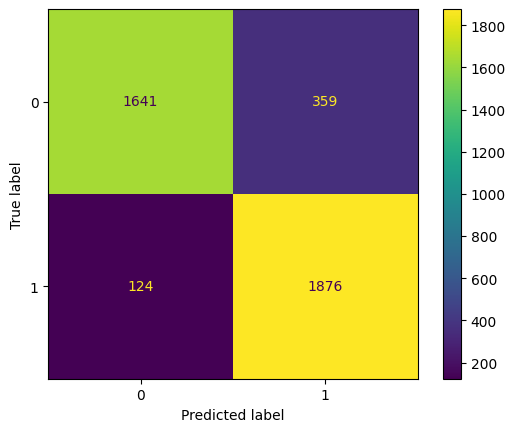

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Experiments**

In the following section I would like to show further experimentations which might be useful. 

First thing first, I would like to show how, if the relations are not mapped to the human readable text, the model struggles a lot. This is because of the fact that ModernBERT is pretrained on text, meaning that if the text is gibberish or contains only ids, like in this case, the training cannot take advantage of the pretraining of the model itself. 

In [40]:
# reload dataset and fix the fact that tail and relation are inverted
from datasets import load_dataset
import tqdm as notebook_tqdm
# FB15k-237 from HuggingFace
dataset = load_dataset("VLyb/FB15k-237")

train_triples = dataset["train"]
test_triples = dataset["test"]
valid_triples = dataset["validation"]
print(train_triples[0])


def fix_fields(example):
    return {
        "head": example["head"],
        "relation": example["tail"],
        "tail": example["relation"]
    }

train_dataset = dataset["train"].map(fix_fields)
valid_dataset = dataset["validation"].map(fix_fields)
test_dataset  = dataset["test"].map(fix_fields)

{'head': '/m/027rn', 'relation': '/m/06cx9', 'tail': '/location/country/form_of_government'}


In [41]:
train_subset_size = 10000
val_test_subset_size = 2000

train_triples = train_dataset.select(range(train_subset_size))
valid_triples = valid_dataset.select(range(val_test_subset_size))
test_triples  = test_dataset.select(range(val_test_subset_size))

In [42]:
def triple_to_sentence_not_mapped(h, r, t):
    return f"{h} {r} {t}."

h = train_triples[0]['head']
r = train_triples[0]['relation']
t = train_triples[0]['tail']
sentence = triple_to_sentence_not_mapped(h, r, t)
sentence

'/m/027rn /location/country/form_of_government /m/06cx9.'

In [43]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer -- ModernBERT
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model = AutoModel.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model.eval()

ModernBertModel(
  (embeddings): ModernBertEmbeddings(
    (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (layers): ModuleList(
    (0): ModernBertEncoderLayer(
      (attn_norm): Identity()
      (attn): ModernBertAttention(
        (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
        (rotary_emb): ModernBertRotaryEmbedding()
        (Wo): Linear(in_features=768, out_features=768, bias=False)
        (out_drop): Identity()
      )
      (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): ModernBertMLP(
        (Wi): Linear(in_features=768, out_features=2304, bias=False)
        (act): GELUActivation()
        (drop): Dropout(p=0.0, inplace=False)
        (Wo): Linear(in_features=1152, out_features=768, bias=False)
      )
    )
    (1-21): 21 x ModernBertEncoderLayer(
      (attn_norm): LayerNorm((768,), eps=1e-05, e

In [44]:
all_entities = set()

for split in [train_triples, test_triples, valid_triples]:
    for row in split:
        all_entities.update([row["head"], row["tail"]])
all_entities = list(all_entities)

In [45]:
def make_labeled_data_not_mapped(triples, all_entities, corrupt_fn):
    data = []
    for triple in triples:
        h, r, t = triple["head"], triple["relation"], triple["tail"]
        pos_sentence = triple_to_sentence_not_mapped(h, r, t)
        data.append((pos_sentence, 1))

        ch, cr, ct = corrupt_fn(triple, all_entities)
        neg_sentence = triple_to_sentence_not_mapped(ch, cr, ct)
        data.append((neg_sentence, 0))
    return data

# create the proper data to train, validate and test the model
# each is going to contain double the data they start with as for every triple we have a positive and a negative
train_data_not_mapped = make_labeled_data_not_mapped(train_triples, all_entities, corrupt_triple2)
val_data_not_mapped = make_labeled_data_not_mapped(valid_triples, all_entities, corrupt_triple2)
test_data_not_mapped = make_labeled_data_not_mapped(test_triples, all_entities, corrupt_triple2)


# tokenize the data using the function defined in the previous step as there is no difference here
train_tokenized_not_mapped = tokenize_data(train_data_not_mapped)
val_tokenized_not_mapped = tokenize_data(val_data_not_mapped)
test_tokenized_not_mapped = tokenize_data(test_data_not_mapped)

In [46]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)

In [47]:
from torch.utils.data import Dataset, DataLoader

class PreTokenizedDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

train_loader = DataLoader(PreTokenizedDataset(train_tokenized_not_mapped), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(PreTokenizedDataset(val_tokenized_not_mapped), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(PreTokenizedDataset(test_tokenized_not_mapped), batch_size=32, collate_fn=collate_fn)

In [48]:
import torch.nn as nn
from transformers import AutoModel

class TripleClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.encoder = base_model
        self.classifier = nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls).squeeze(-1)
        return logits


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = AutoModel.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model = TripleClassifier(base_model)
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
model.train()

TripleClassifier(
  (encoder): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      )
      (1-21): 2

In [51]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

    model.train()
    accuracy = total_correct / total_examples
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy


In [52]:
for epoch in range(5):
    total_train_loss = 0
    total_train_correct = 0
    total_train_examples = 0
    model.train()

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        total_train_correct += (preds == labels).sum().item()
        total_train_examples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = total_train_correct / total_train_examples

    avg_val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1 | Train Loss: 0.6981 | Train Acc: 0.4983 | Val Loss: 0.6937 | Val Acc: 0.5000
Epoch 2 | Train Loss: 0.6960 | Train Acc: 0.4977 | Val Loss: 0.6926 | Val Acc: 0.5212
Epoch 3 | Train Loss: 0.6944 | Train Acc: 0.5072 | Val Loss: 0.7038 | Val Acc: 0.5015
Epoch 4 | Train Loss: 0.6919 | Train Acc: 0.5129 | Val Loss: 0.6900 | Val Acc: 0.5225
Epoch 5 | Train Loss: 0.6885 | Train Acc: 0.5312 | Val Loss: 0.6878 | Val Acc: 0.5453


In [53]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6853 | Test Accuracy: 0.5337


As expected, the model fails to learn when provided with only symbolic triples. Loss stagnates at 0.693 and accuracy remains near 50%, equivalent to random guessing. This validates our hypothesis that ModernBERT requires semantically meaningful input to be effective in link prediction.

In [54]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend((probs > 0.5).float().cpu().numpy())

In [55]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.5206    0.8540    0.6468      2000
         1.0     0.5939    0.2135    0.3141      2000

    accuracy                         0.5337      4000
   macro avg     0.5572    0.5337    0.4805      4000
weighted avg     0.5572    0.5337    0.4805      4000



In [56]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(all_labels, all_probs)
print(f"ROC AUC: {auc:.4f}")

ROC AUC: 0.5737


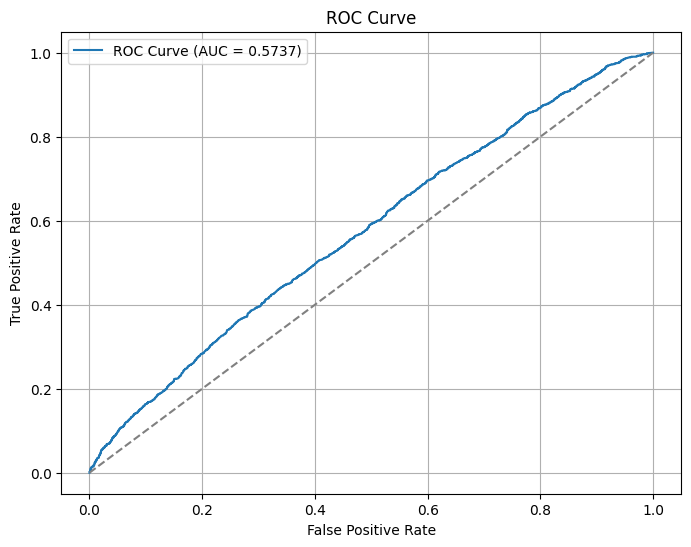

In [57]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

From the ROC-AUC curve as well as from the classification report, it is fairly evident how less accurately the model performs when the data is not correctly encoded. Therefore, it is important to have phrases which more or less make sense when using ModernBERT as otherwise you cannot take advantage of the pretraining. 

## Brief literature review

Research is no stranger to the phenomenon observed in the development of this notebook. Many papers have been written on the topic, and they all prove that language models can be used to predict links, entities, and in my case the mere existence of triples if and only if these triples are transformed into natural language sentences.

First, the paper written by Yao et al. in 2019 titled "KG-BERT: BERT for Knowledge Graph Completion" (https://arxiv.org/abs/1909.07606) laid important groundwork for integrating language models into structured knowledge tasks, specifically concerning knowledge graphs, like in this case. They, much like what is done in the previous sections of my work, propose to transform the triples into human-like sentences and feed them into BERT to determine their plausibility. In my work, I mirrored what was done in this paper by transforming triples from the FB15k-237 dataset into human-readable phrases and using ModernBERT for binary classification, and supported their finding: that language models can perform link prediction if the structured data is linguistically contextualized.

Furthermore, these findings are supported also by the paper written by Petroni et al., available at the following lin: https://aclanthology.org/D19-1250.pdf and written in 2019, takes into account ModernBERT and how this model can be used as a functional knowledge base when presented with factual information in natural language form. This relates to how I, in my work, convert the triples in the dataset, which are entirely encoded into indices, into natural language phrases. My findings are in line with the ones described in the paper, therefore that when the entities and relations are not mapped and are left as opaque identifiers, the model performance drops significantly, and even after extensive training the results are not satisfactory. 